# Wind-spreading kernels

What do the kernels look like? Let's plot them!

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate

from ocr.risks.fire import generate_weights, generate_wind_directional_kernels

In [2]:
weights_dict = generate_wind_directional_kernels()

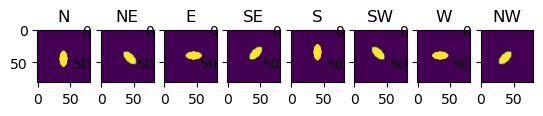

In [4]:
fig, axarr = plt.subplots(ncols=8)
for i, direction in enumerate(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']):
    axarr[i].imshow(weights_dict[direction])
    axarr[i].set_title(direction)

We can see that the kernels are oriented such that the north one pulls from higher index values (aka northward) but that is plotted down in imshow.

To explain this more we can recreate the flip the directions in the function. This is WRONG but is a way to show us why it's so important to get the wind direction labels in the right order!

In [16]:
def generate_wind_directional_kernels(
    kernel_size: float = 81.0, circle_diameter: float = 35.0
) -> dict[str, np.ndarray]:
    """Generate a dictionary of 2D arrays of weights for ellptical kernels oriented in different directions.

    Parameters
    ----------
    kernel_size : float, optional
        The size of the kernel, by default 81.0
    circle_diameter : float, optional
        The diameter of the circle, by default 35.0

    Returns
    -------
    kernels : dict[str, np.ndarray]
        A dictionary of 2D arrays of weights for elliptical kernels oriented in different directions.
    """
    weights_dict = {}
    rotating_angles = np.arange(0, 360, 45)
    # CHANGING THE WIND DIRECTION LABELS TO THE WRONG ORIENTATION
    wind_direction_labels = ['W', 'SW', 'S', 'SE', 'E', 'NE', 'N', 'NW']
    for angle, direction in zip(rotating_angles, wind_direction_labels):
        # our base kernel is oriented to the west
        base = generate_weights(
            method='skewed', kernel_size=kernel_size, circle_diameter=circle_diameter
        ).astype(np.float32)
        # rotating we rotate the kernel and pair it with each direction
        # when you plot these kernels with imshow (aka with y coordinates inverted),
        # north is at the bottom and south is at the top. thus, we want the elliptical
        # kernel to be toward the bottom of a figure when you plot the
        # weights in imshow.
        # Note: rotate will introduce some non 0/1 values for the ellipses in the ordinal directions
        # but they are normalized so the total weight is consistent.
        rotated = rotate(
            base,
            angle=angle,
            reshape=False,  # keep original shape
            order=1,  # bilinear to reduce ringing
            mode='nearest',
            prefilter=False,
        )
        # Remove tiny negative interpolation artifacts, renormalize
        rotated = np.clip(rotated, 0.0, None)
        weights_dict[direction] = rotated

    # re-normalize all weights to ensure sum equals 1.0
    for direction in weights_dict:
        s = weights_dict[direction].sum()
        if s > 0:
            weights_dict[direction] = weights_dict[direction] / s
    return weights_dict

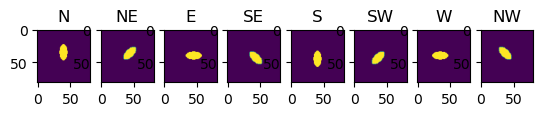

In [17]:
weights_dict = generate_wind_directional_kernels()
fig, axarr = plt.subplots(ncols=8)
for i, direction in enumerate(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']):
    axarr[i].imshow(weights_dict[direction])
    axarr[i].set_title(direction)

These kernels _look_ like the match the directions titling each of the plots, but that's because the plots are oriented with north pointing down!